In [171]:
%matplotlib inline

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

HEIGHT = 224
WIDTH = 224

In [172]:
#split in training and validation data https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#yay, also works on dataframes: https://stackoverflow.com/a/24151789/227081

train, valid = train_test_split(pd.read_csv('train.tsv', sep='\t', header=0), test_size=0.2)
print(train.size)
print(train.head())
print(valid.size)
valid.head()



11612
           file                          label
5305   5308.png                    Fresh bread
5621  5625.jpeg             Berries & cherries
5716   5720.png        Bananas, apples & pears
4868   4870.png  Cucumber, tomatoes & avocados
7049  7054.jpeg                  Citrus fruits
2904


,file,label
5660,5664.jpeg,"Asparagus, string beans & brussels sprouts"
639,639.png,Citrus fruits
3146,3146.png,"Bell peppers, zucchinis & eggplants"
5205,5208.png,Citrus fruits
2298,2298.png,Citrus fruits


In [173]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(HEIGHT, WIDTH))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(prefix, img_paths):
    list_of_tensors = [path_to_tensor(prefix + img_path) for img_path in tqdm(img_paths)]
    return preprocess_input(np.vstack(list_of_tensors))

X_train = paths_to_tensor("train/", np.array(train['file']))
X_valid = paths_to_tensor("train/", np.array(valid['file']))

  0%|                                                                                         | 0/5806 [00:00<?, ?it/s]C:\app\Anaconda3\envs\picnic-hackathon\lib\site-packages\PIL\Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
100%|██████████████████████████████████████████████████████████████████████████████| 1452/1452 [01:15<00:00, 21.69it/s]


file                   1597.jpeg
label    Minced meat & meatballs
Name: 1597, dtype: object


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


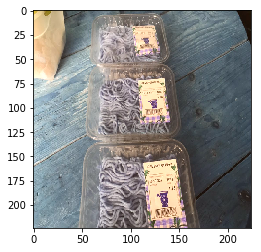

In [174]:
print(valid.iloc[10])
plt.imshow((X_valid[10]+128.)/255.)
#note colors are not correct because of Keras Resnet50 preprocessing
# can probably fix this through this: https://stackoverflow.com/questions/38538952/how-to-swap-blue-and-green-channel-in-an-image-using-opencv


In [175]:
#quick test to see if we detect a banana (954)
#dictionary is at https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
ResNet50_model = ResNet50(weights='imagenet')
np.argmax(ResNet50_model.predict(np.expand_dims(X_valid[10], axis=0)))

692

In [176]:
labels = train['label'].unique()
labels

array(['Fresh bread', 'Berries & cherries', 'Bananas, apples & pears',
       'Cucumber, tomatoes & avocados', 'Citrus fruits',
       'Bell peppers, zucchinis & eggplants', 'Potatoes',
       'Pre-baked breads', 'Broccoli, cauliflowers, carrots & radish',
       'Eggs', 'Cheese', 'Pudding, yogurt & quark', 'Milk',
       'Minced meat & meatballs', 'Pork, beef & lamb', 'Poultry',
       'Salad & cress', 'Kiwis, grapes & mango',
       'Onions, leek, garlic & beets', 'Fresh herbs', 'Fish',
       'Nectarines, peaches & apricots',
       'Asparagus, string beans & brussels sprouts',
       'Pineapples, melons & passion fruit', 'Lunch & Deli Meats'],
      dtype=object)

In [177]:
one_hot_encoding = preprocessing.LabelBinarizer()
one_hot_encoding.fit(labels)
y_train = one_hot_encoding.transform(np.array(train['label']))
y_valid = one_hot_encoding.transform(np.array(valid['label']))
one_hot_encoding.inverse_transform(np.array([y_valid[10]]))

array(['Minced meat & meatballs'], dtype='<U42')

In [179]:
print(len(train))
print(len(X_train))
print(len(y_train))
print(len(X_valid))
print(len(y_valid))

5806
5806
5806
1452
1452


In [180]:
model = Sequential()
model.add(ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3)))
for layer in model.layers:
    layer.trainable = False

C:\app\Anaconda3\envs\picnic-hackathon\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [181]:
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(labels.size, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 25)                25625     
Total params: 25,711,513
Trainable params: 2,123,801
Non-trainable params: 23,587,712
_________________________________________________________________


In [182]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.1)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [183]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          epochs=200, batch_size=20, callbacks=[checkpointer], verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 5806 samples, validate on 1452 samples
Epoch 1/200
 760/5806 [==>...........................] - ETA: 4:25:36 - loss: 3.8867 - acc: 0.05 - ETA: 2:24:58 - loss: 4.7602 - acc: 0.02 - ETA: 1:44:28 - loss: 4.6528 - acc: 0.06 - ETA: 1:24:29 - loss: 4.3472 - acc: 0.06 - ETA: 1:12:14 - loss: 4.2877 - acc: 0.07 - ETA: 1:04:00 - loss: 4.2458 - acc: 0.08 - ETA: 57:59 - loss: 4.1310 - acc: 0.1071 - ETA: 53:35 - loss: 3.9912 - acc: 0.12 - ETA: 50:09 - loss: 3.8680 - acc: 0.13 - ETA: 47:22 - loss: 3.7623 - acc: 0.14 - ETA: 45:04 - loss: 3.7093 - acc: 0.13 - ETA: 43:09 - loss: 3.6082 - acc: 0.15 - ETA: 41:29 - loss: 3.5211 - acc: 0.17 - ETA: 40:03 - loss: 3.3984 - acc: 0.20 - ETA: 38:47 - loss: 3.3129 - acc: 0.21 - ETA: 37:38 - loss: 3.2477 - acc: 0.22 - ETA: 36:40 - loss: 3.2087 - acc: 0.22 - ETA: 35:41 - loss: 3.2000 - acc: 0.23 - ETA: 34:55 - loss: 3.1651 - acc: 0.23 - ETA: 34:12 - loss: 3.1301 - acc: 0.23 - ETA: 33:34 - loss: 3.1144 - acc: 

KeyboardInterrupt: 

In [ ]:
# TODO
#model.load_weights('saved_models/weights.best.from_scratch.hdf5')
# load test file into "tensor" and get prediction ->
# np.argmax(model.predict(np.expand_dims(tensor, axis=0)))

# write to TSV